In [1]:
import pandas as pd
import pymc3 as pm
import arviz as az
from arviz_json import get_dag, arviz_to_json
from sklearn.linear_model import LinearRegression
import numpy as np
from visualization import lreg_plot, line_points, kruschke_style_posteriors, homogenous_models_outputs, hom_het_hi_reg_line

## constants
samples=2000
chains=2
tune=1000

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Loading

In [2]:
## data from Belenky et al. (2003)
## retrieved from https://benlambertdotcom.files.wordpress.com/2018/08/all_data.zip
dataFile = 'evaluation_sleepstudy.csv'
reactions = pd.read_csv(dataFile, usecols = ['Reaction','Days','Subject'])

# Linear Regression Model

We regress drivers' reaction time on the number of consecutive days of driving under sleep-deprivation conditions.

## Ordinary Least Squares (OLS)

In [3]:
x = np.array(reactions.Days).reshape(-1, 1)
y = np.array(reactions.Reaction).reshape(-1, 1)
reg = LinearRegression().fit(x, y)
##
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]
reaction_time = reg.predict(np.array([[3]]))[0][0]
print("The R^2 correlation is", reg.score(x, y))
print("The slope b is", reg.coef_[0][0])
print("The intercept a is", reg.intercept_[0])
print("The predicted reaction time of a driver after 3 consecutive days of driving under sleep-deprivation conditions is", 
      reg.predict(np.array([[3]]))[0][0], "ms")

The R^2 correlation is 0.28647139510771
The slope b is 10.467285959595957
The intercept a is 251.40510484848483
The predicted reaction time of a driver after 3 consecutive days of driving under sleep-deprivation conditions is 282.8069627272727 ms


<AxesSubplot: xlabel='Days of Driving', ylabel='Reaction Time (ms)'>

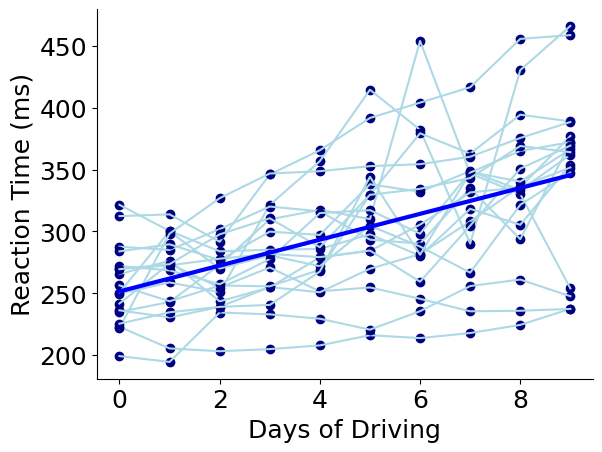

In [4]:
## Plot regression line
lreg_plot(reactions, reg.coef_[0][0], reg.intercept_[0])    

## Bayesian Probabilistic Linear Regression 

### Homogenous Model
In this case data is treated as a single group and pooled together. The parameters are fixed across all data.

In [5]:
dataFile = 'evaluation_sleepstudy.csv'
reactions = pd.read_csv(dataFile, 
                        usecols = ['Reaction','Days','Subject'])
with pm.Model() as homogenous_model:
    ## priors
    a = pm.Normal("a", mu = 100, sd = 100)
    b = pm.Normal("b", mu = 10, sd = 10)
    s = pm.HalfNormal("s", sd = 50)
    ## likelihood
    rt = pm.Normal("rt",mu = a + b*reactions.Days, 
                        sd = s, 
                        observed = reactions.Reaction)
    
    ## INFERENCE
    ## Get posterior trace, prior and posterior predictive samples
    trace = pm.sample(draws = samples, chains = chains, tune = tune)
    prior = pm.sample_prior_predictive(samples = samples)
    posterior_predictive = pm.sample_posterior_predictive(trace,
                                                          samples = samples)        
    
    ## Get the DAG of the model
    dag = get_dag(homogenous_model)

    ## Export inference results in ArviZ InferenceData obj
    data = az.from_pymc3(trace = trace, 
                         prior = prior, 
                         posterior_predictive = posterior_predictive)
    
    ## Insert dag into sampler stat attributes
    data.sample_stats.attrs["graph"] = str(dag)
    
    ## Save model+inference output to npz file 
    fileName = "reaction_fullyPooled_PyMC3"
    # arviz_json.arviz_to_json(data, fileName+'.npz')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [s, b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
C:\Users\evita\Anaconda3\envs\myenv\lib\site-packages\pymc3\sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable rt's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


## Posterior Summary Statistics

In [6]:
az.summary(trace,kind='stats',hdi_prob=0.97)

C:\Users\evita\Anaconda3\envs\myenv\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_1.5%,hdi_98.5%
a,251.000,6.717,236.841,265.724
b,10.516,1.262,8.016,13.377
s,47.961,2.640,42.352,53.619


## Posterior Distributions in Kruschke style

C:\Users\evita\Anaconda3\envs\myenv\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


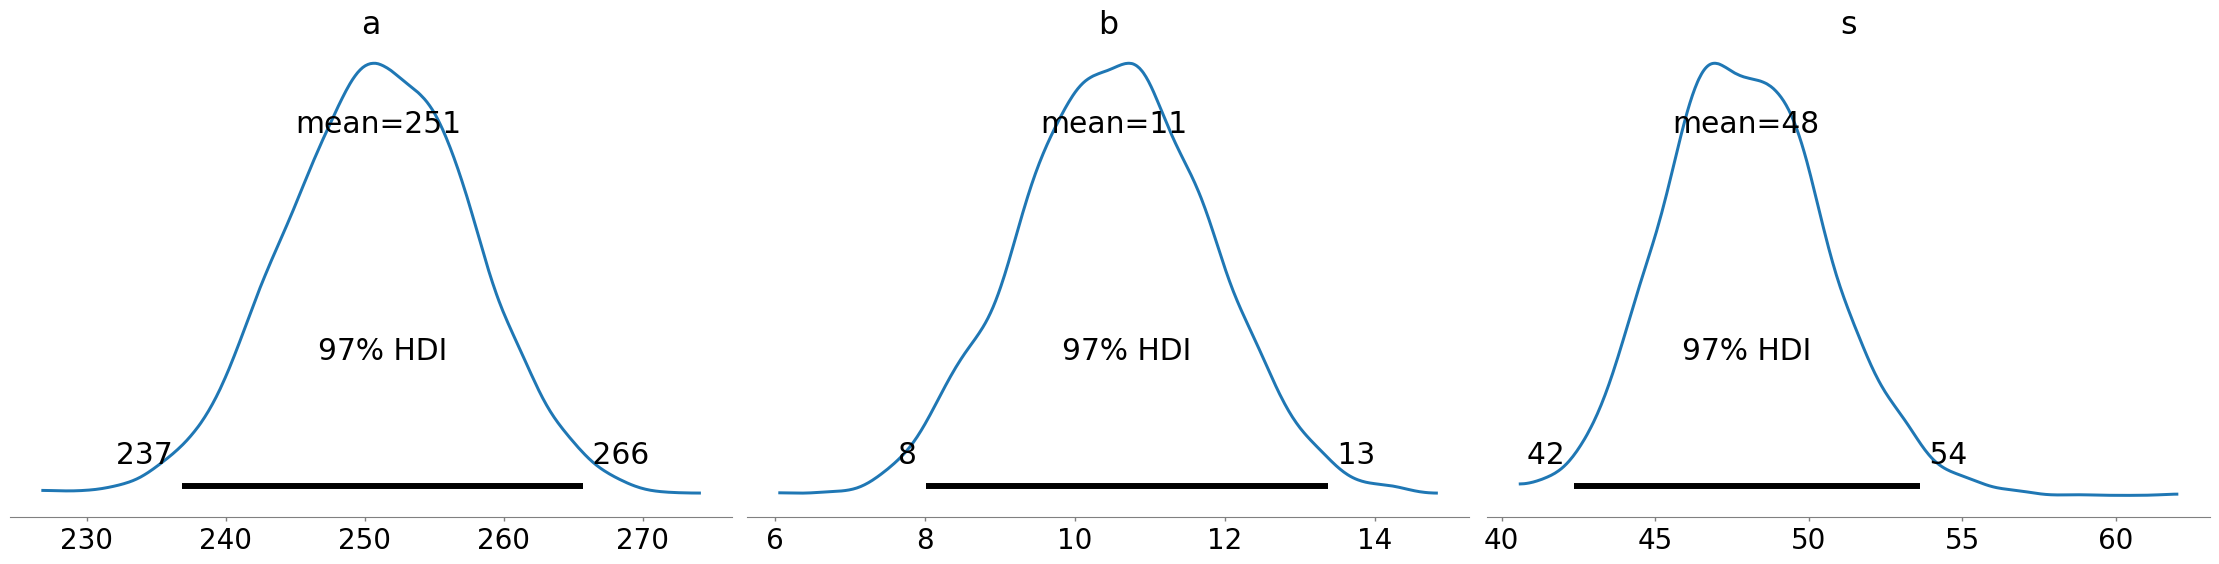

In [7]:
kruschke_style_posteriors(trace)

## Outputs of Probabilistic and Non-Probabilistic Model

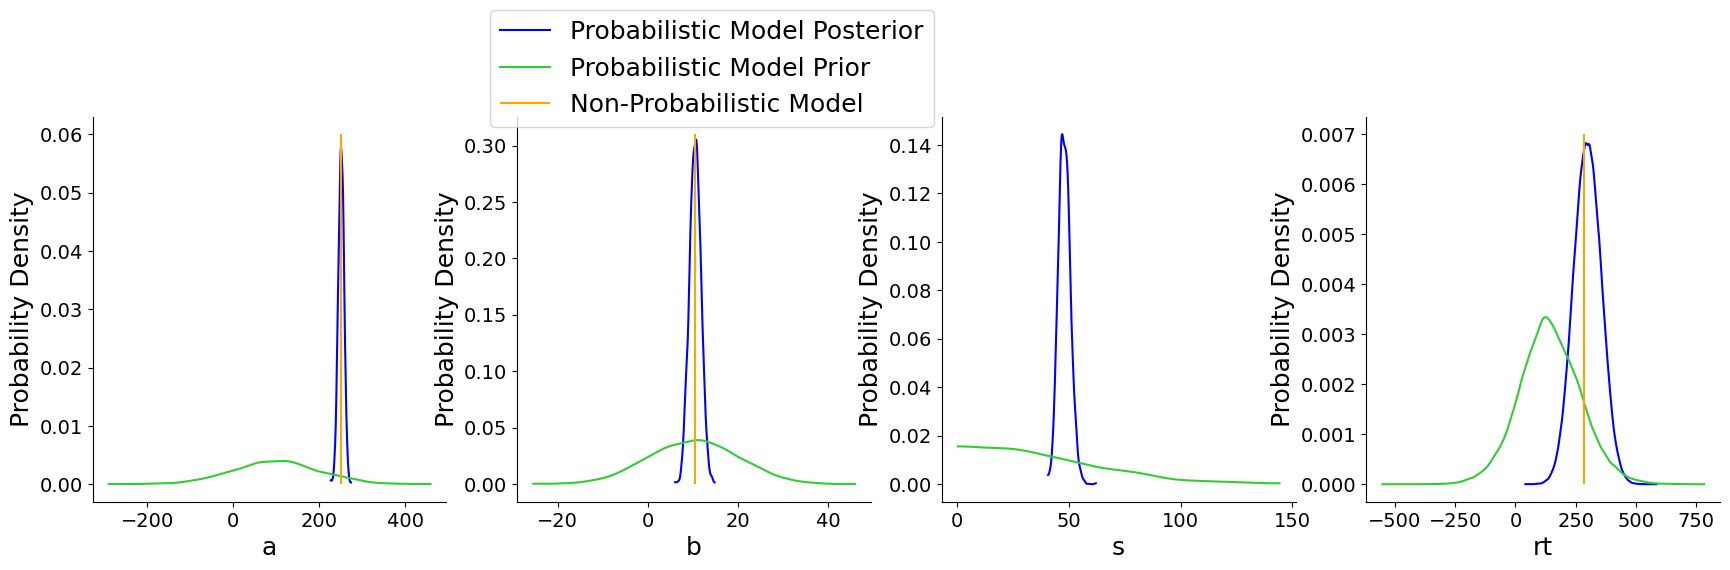

In [8]:
homogenous_models_outputs(trace, prior, posterior_predictive, slope, intercept, reaction_time)

NameError: name 'y_rev' is not defined

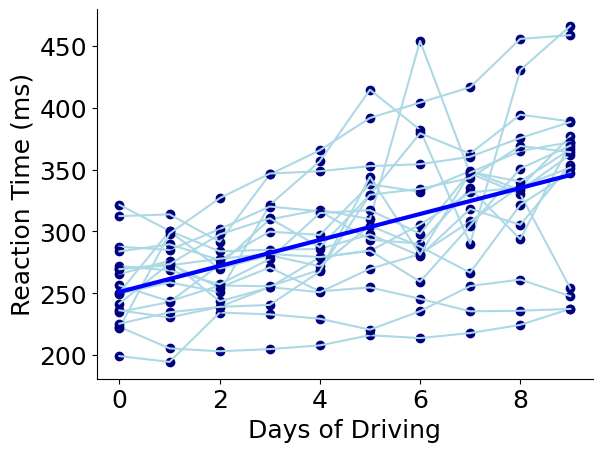

In [9]:
ax = lreg_plot(reactions, trace.b.mean(), trace.a.mean())
az.plot_hdi(reactions.Days.unique(), 
            y_rev, 
            color = "blue", ax = ax, plot_kwargs={"ls": "--"}, fill_kwargs={'alpha': 0.5})

In [ ]:
# ax = lreg_plot(reactions, trace.b.mean(), trace.a.mean())
# az.plot_hdi(reactions.Days.unique(), 
#             np.array([posterior_predictive['rt'][:,[s*len(reactions.Days.unique())+day for s in range(len(reactions.Subject.unique()))]].flatten() for day in reactions.Days.unique()]), 
#             color = "blue", ax = ax, plot_kwargs={"ls": "--"}, fill_kwargs={'alpha': 0.5})

## Heterogenous Model
In this case a separated model for each group (driver) will be estimated. This model will allow inference only on the groups level.

In [10]:
## Prepare data
driver_idx, drivers = pd.factorize(reactions["Subject"], sort=False)
 
## Define coordinates and dimensions for the parameters
coords_het = {"driver": drivers, "driver_idx_day": reactions.Subject}
with pm.Model(coords = coords_het) as heterogeneous_model:
    ## MODEL DEFINITION
    ## priors
    a = pm.Normal("a", mu = 100, sd = 100, dims = "driver")
    b = pm.Normal("b", mu = 10, sd = 10, dims = "driver")
    s = pm.HalfNormal("s", sd = 50, dims = "driver")
    ## likelihood
    rt = pm.Normal('rt',
                       mu = a[driver_idx] + b[driver_idx]*reactions.Days,
                       sd = s[driver_idx],
                       observed = reactions.Reaction, 
                       dims = "driver_idx_day")
    
    ## INFERENCE
    ## Get posterior trace, prior and posterior predictive samples
    trace_het = pm.sample(draws = samples, chains = chains, tune = tune)
    prior_het = pm.sample_prior_predictive(samples = samples)
    posterior_predictive_het = pm.sample_posterior_predictive(trace_het, 
                                                             samples = samples)  
    ## Get the DAG of the model
    dag_het = get_dag(heterogeneous_model)

    ## Export inference results in ArviZ InferenceData obj
    data_het = az.from_pymc3(trace = trace_het, 
                            prior = prior_het, 
                            posterior_predictive = posterior_predictive_het)

    ## Insert dag into sampler stat attributes
    data_het.sample_stats.attrs["graph"] = str(dag_het)

    ## save model+inference output to npz file   
    # fileName_het = "reaction_heterogenous_PyMC3"
    # arviz_to_json(data_het, fileName_het+'.npz')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [s, b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.


0, dim: driver_idx_day, 180 =? 180


C:\Users\evita\Anaconda3\envs\myenv\lib\site-packages\pymc3\sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable rt's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: driver_idx_day, 180 =? 180


### Hierarchical Model
In this case data is partially pooled across the groups by setting a higher-level of shared priors, the hyper-priors. Instead of fixing the parameters of the model’s priors to constant numbers, we estimate them directly from the data by placing shared priors over them. This allows the model to deal with inferences at the group (here individual driver) level and estimations above the group (individual driver) level.

In [12]:
## Prepare data
driver_idx, drivers = pd.factorize(reactions["Subject"], sort=False)
day_idx, days = pd.factorize(reactions["Days"], sort=False)

## Define coordinates and dimensions for the parameters
coords_h = {"driver": drivers, "driver_idx_day": reactions.Subject}
with pm.Model(coords=coords_h) as hierarchical_model:
    ## MODEL DEFINITION
    ## hyper-priors
    mu_a = pm.Normal('mu_a', mu = 100, sd = 100)
    sigma_a = pm.HalfNormal('sigma_a', sd = 100)
    mu_b = pm.Normal('mu_b', mu = 10, sd = 10)
    sigma_b = pm.HalfNormal('sigma_b', sd=10)
    sigma_s = pm.HalfNormal('sigma_s', sd = 50)
    ## priors
    a = pm.Normal("a", mu = mu_a, sd = sigma_a, dims = "driver")
    b = pm.Normal("b", mu = mu_b, sd = sigma_b, dims = "driver")
    s = pm.HalfNormal("s", sd = sigma_s, dims = "driver") 
    ## likelihood
    rt = pm.Normal('rt', 
                       mu = a[driver_idx] + b[driver_idx]*day_idx, 
                       sd = s[driver_idx], 
                       observed = reactions.Reaction, 
                       dims = "driver_idx_day")
    ## INFERENCE
    ## Get posterior trace, prior and posterior predictive samples
    trace_hi = pm.sample(draws = samples, chains = chains, tune = tune)
    prior_hi = pm.sample_prior_predictive(samples = samples)
    posterior_predictive_hi = pm.sample_posterior_predictive(trace_hi, 
                                                             samples = samples)  
    ## Get the DAG of the model
    dag_hi = get_dag(hierarchical_model)

    ## Export inference results in ArviZ InferenceData obj
    data_hi = az.from_pymc3(trace = trace_hi, 
                            prior = prior_hi, 
                            posterior_predictive = posterior_predictive_hi)

    ## Insert dag into sampler stat attributes
    data_hi.sample_stats.attrs["graph"] = str(dag_hi)

    ## save model+inference output to npz file   
    # fileName_hi = "reaction_hierarchical_PyMC3"
    # arviz_to_json(data_hi, fileName_hi+'.npz')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [s, b, a, sigma_s, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 23 seconds.


0, dim: driver_idx_day, 180 =? 180


C:\Users\evita\Anaconda3\envs\myenv\lib\site-packages\pymc3\sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable rt's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: driver_idx_day, 180 =? 180


## Regression Lines Estimates from the Homogenous, Heterogenous, and Hierarchical Model

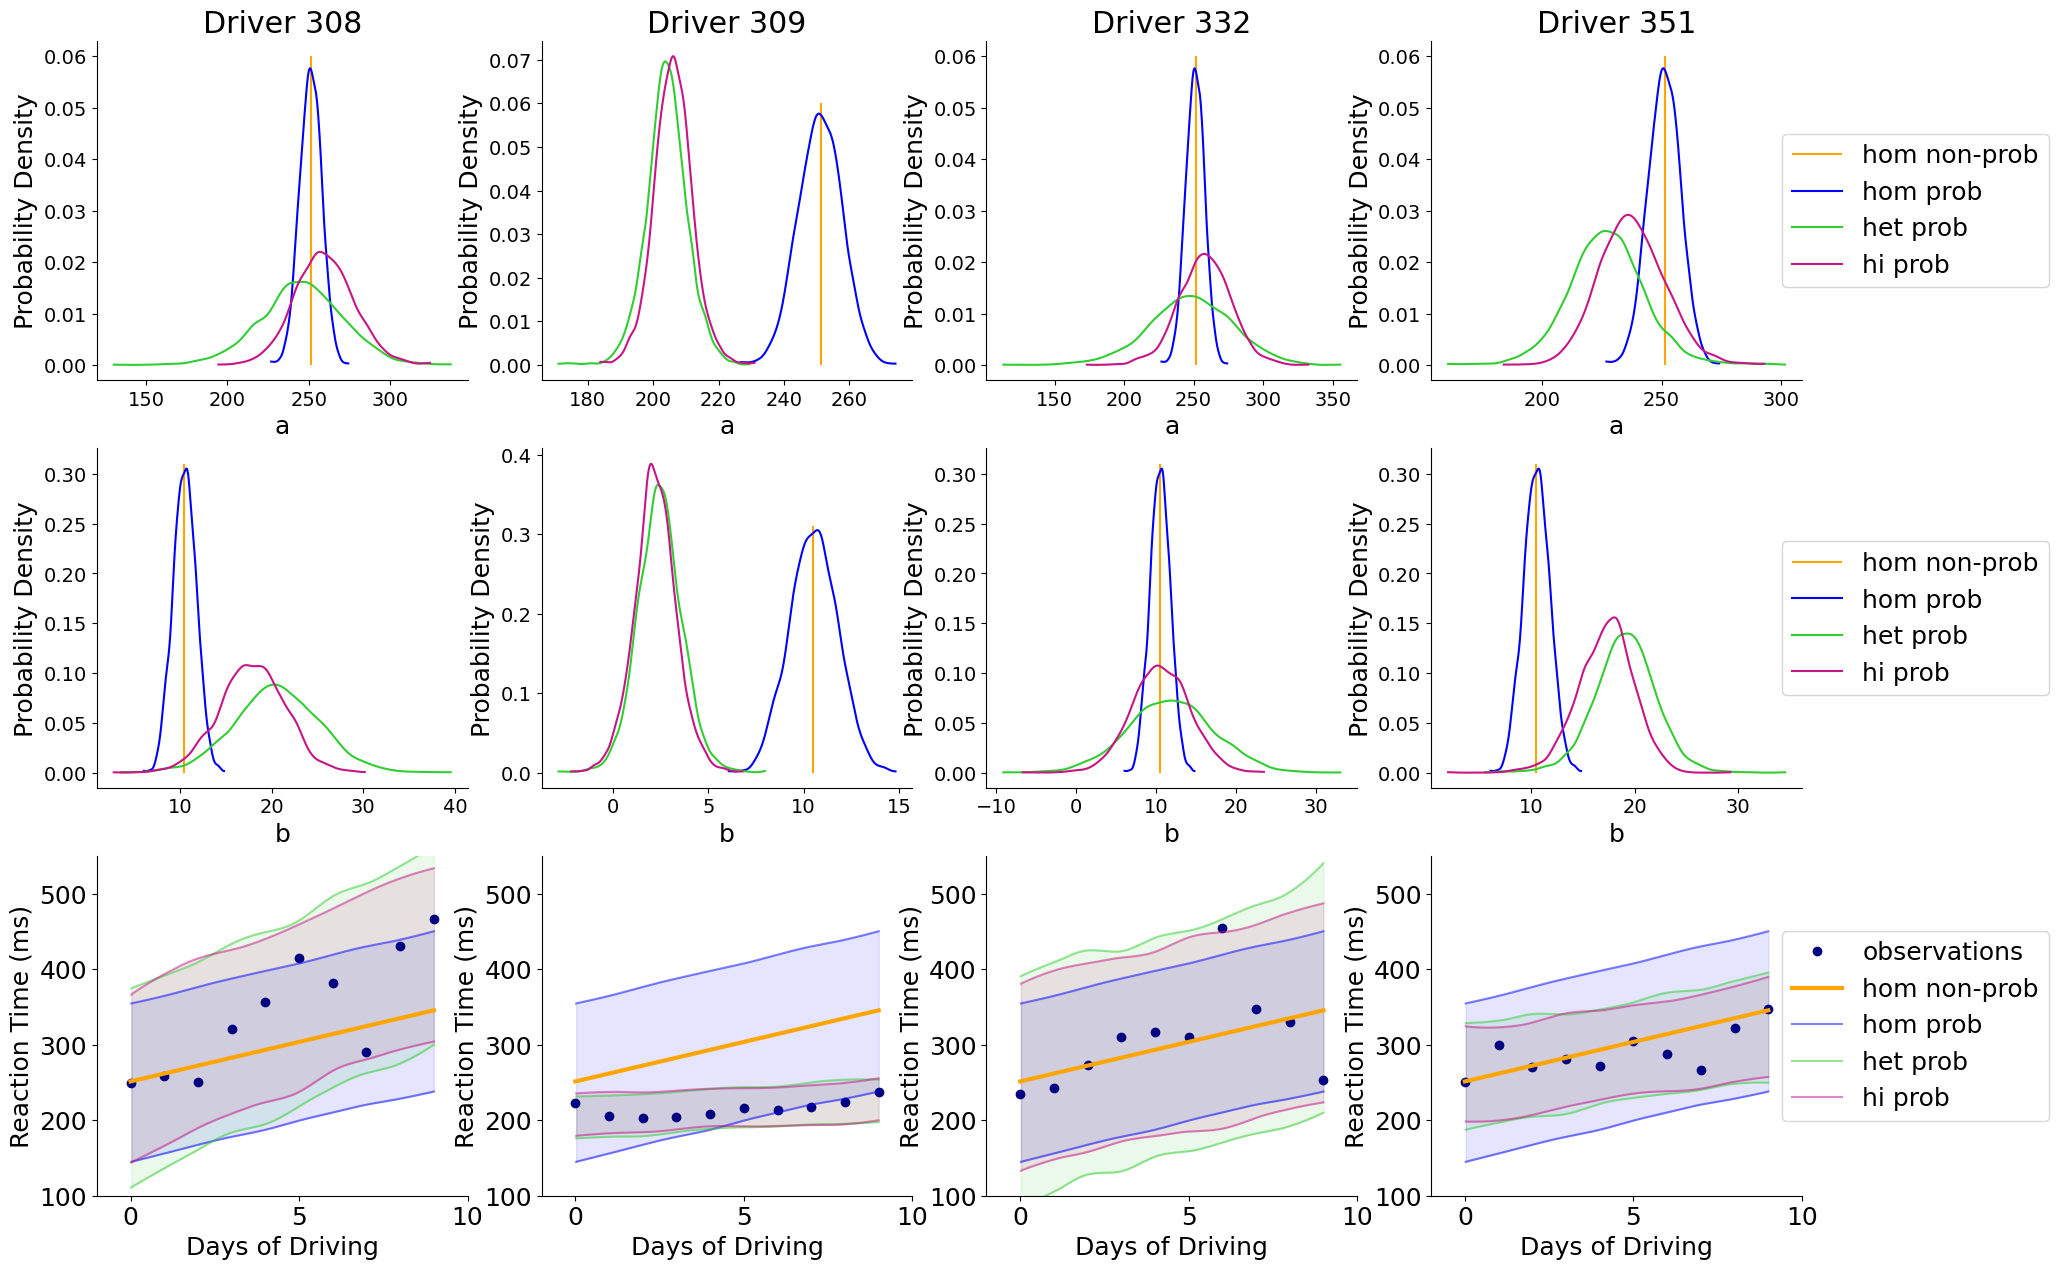

In [13]:
hom_het_hi_reg_line(reactions, trace, trace_het, trace_hi, posterior_predictive, posterior_predictive_het, posterior_predictive_hi, slope, intercept)

### Plot Prior - Posterior - Likelihood

In [6]:
logp = homogenous_model.logp
model_logps = np.array([logp(point) for point in trace.points()])
model_logps.shape
# for point in trace.points():
#     print(point, logp,logp(point))
with homogenous_model:
    obs_logp = a.logp
    likelihood = np.array([np.exp(obs_logp({'a':v,'b':prior['b'][i],'s':prior['s'][i],'s_log__':prior['s_log__'][i]})) for i,v in enumerate(prior['a'])])
    print(likelihood)
    a_points = [p for p in prior['a']]
    # for point in trace.points():
    #     print(point)

[0.00329003 0.00394654 0.0039144  ... 0.00373471 0.00286486 0.00043989]


In [7]:
np.exp(likelihood[0])

0.0013110040629947257

Text(0.5, 0, 's')

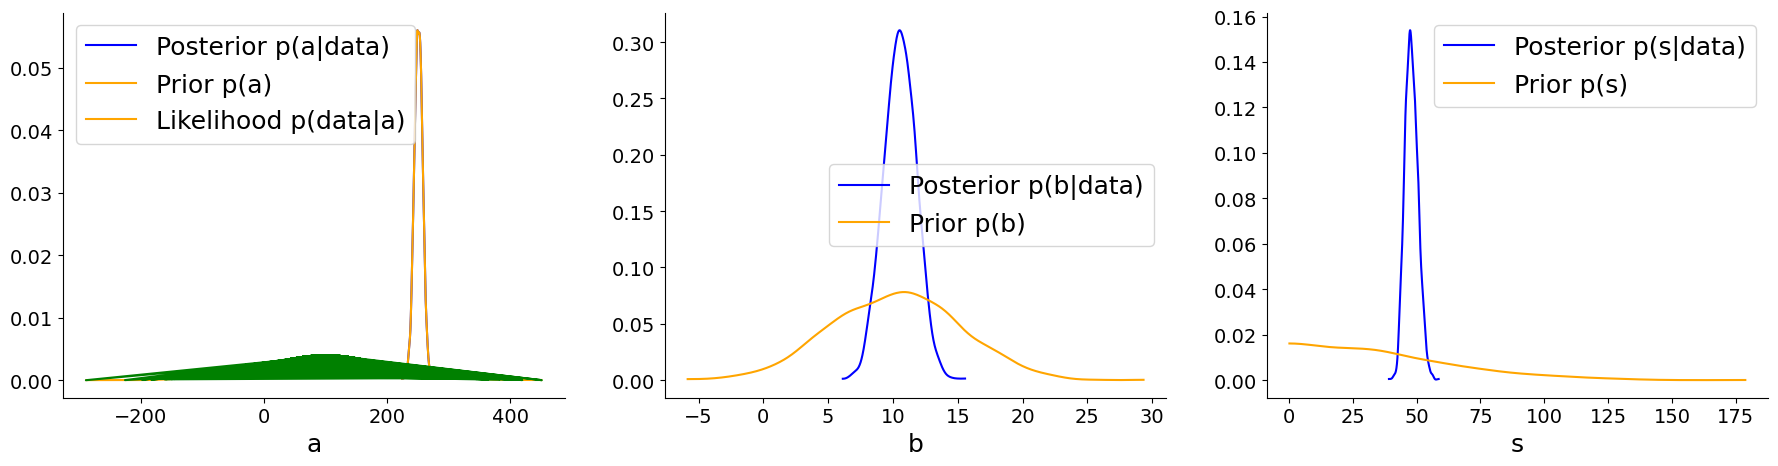

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
c1 = "blue"
c2 = "orange"
c3 = "green"
c4 = "red"
fig, ax = plt.subplots(1, 3, sharey = False,figsize=(22, 5))

## a
az.plot_dist(trace['a'], color=c1, ax=ax[0], label="Posterior p(a|data)")
az.plot_dist(prior['a'], color=c2, ax=ax[0], label="Prior p(a)")
az.plot_dist(trace['a'], color=c2, ax=ax[0], label="Likelihood p(data|a)")
ax[0].plot(a_points,likelihood, c = c3)

## b
az.plot_dist(trace['b'], color=c1, ax=ax[1], label="Posterior p(b|data)")
az.plot_dist(prior['b'], color=c2, ax=ax[1], label="Prior p(b)")
# ax[1].legend(loc='upper center', bbox_to_anchor=(0.55, 1.2))

## s
az.plot_dist(trace['s'], color=c1, ax=ax[2], label="Posterior p(s|data)")
az.plot_dist(prior['s'], color=c2, ax=ax[2], label="Prior p(s)")
##
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

# ax[0].set_ylabel("Probability")
# ax[1].set_ylabel("Probability")
# ax[2].set_ylabel("Probability")

ax[0].set_xlabel("a")
ax[1].set_xlabel("b")
ax[2].set_xlabel("s")

# plt.savefig('reaction_posterior.pdf', dpi=300, bbox_inches="tight", transparent=True)